[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendCenter-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-27 05:01:42,293] Making new env: ppaquette/DoomDefendCenter-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

0.0 False


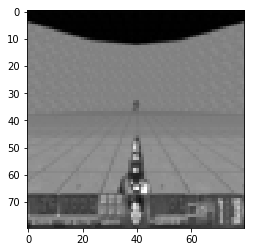

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-27 05:01:43,175] Making new env: ppaquette/DoomDefendCenter-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[3 2 3 3 3 3 0]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 83 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-27 05:02:13,227] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:02:13,237] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-27 05:02:13,481] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.20483.video000000.mp4


Episode finished after 67 timesteps with reward=0.0


[2017-06-27 05:02:15,273] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.20483.video000001.mp4


Episode finished after 82 timesteps with reward=1.0
Episode finished after 62 timesteps with reward=0.0
Episode finished after 52 timesteps with reward=0.0
Episode finished after 55 timesteps with reward=0.0
Episode finished after 90 timesteps with reward=1.0
Episode finished after 61 timesteps with reward=0.0


[2017-06-27 05:02:22,678] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.20483.video000008.mp4


Episode finished after 70 timesteps with reward=1.0
Episode finished after 69 timesteps with reward=0.0


[2017-06-27 05:02:25,668] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 82 timesteps with reward=2.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:02<07:45,  4.27it/s]

iter=10	epsilon=0.954	reward/step=0.00909


  1%|          | 21/2000 [00:05<07:34,  4.35it/s]

iter=20	epsilon=0.910	reward/step=0.00952


  2%|▏         | 31/2000 [00:07<07:30,  4.37it/s]

iter=30	epsilon=0.868	reward/step=0.00323


  2%|▏         | 41/2000 [00:09<07:31,  4.34it/s]

iter=40	epsilon=0.828	reward/step=0.00244


  2%|▏         | 49/2000 [00:11<07:53,  4.12it/s][2017-06-27 05:02:37,596] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:02:37,604] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=0.00588
Episode finished after 71 timesteps with reward=1.0
Episode finished after 60 timesteps with reward=0.0
Episode finished after 56 timesteps with reward=1.0
Episode finished after 57 timesteps with reward=0.0


[2017-06-27 05:02:42,229] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:16<53:35,  1.65s/it]

Episode finished after 77 timesteps with reward=0.0


  3%|▎         | 60/2000 [00:19<09:46,  3.31it/s]

iter=60	epsilon=0.754	reward/step=0.00492


  4%|▎         | 70/2000 [00:21<08:21,  3.85it/s]

iter=70	epsilon=0.719	reward/step=0.00423


  4%|▍         | 80/2000 [00:24<08:17,  3.86it/s]

iter=80	epsilon=0.687	reward/step=0.00494


  4%|▍         | 90/2000 [00:26<08:18,  3.83it/s]

iter=90	epsilon=0.656	reward/step=0.00220


  5%|▍         | 99/2000 [00:28<08:01,  3.95it/s][2017-06-27 05:02:54,775] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:02:54,780] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.00396
Episode finished after 64 timesteps with reward=0.0
Episode finished after 62 timesteps with reward=1.0
Episode finished after 66 timesteps with reward=1.0
Episode finished after 56 timesteps with reward=-1.0


[2017-06-27 05:02:59,332] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [00:33<51:46,  1.63s/it]

Episode finished after 76 timesteps with reward=3.0


  6%|▌         | 110/2000 [00:36<09:42,  3.24it/s]

iter=110	epsilon=0.598	reward/step=0.00541


  6%|▌         | 120/2000 [00:38<08:34,  3.66it/s]

iter=120	epsilon=0.571	reward/step=0.00661


  6%|▋         | 130/2000 [00:41<08:38,  3.61it/s]

iter=130	epsilon=0.546	reward/step=0.00687


  7%|▋         | 140/2000 [00:44<08:40,  3.58it/s]

iter=140	epsilon=0.522	reward/step=0.00709


  7%|▋         | 149/2000 [00:46<08:22,  3.68it/s][2017-06-27 05:03:12,535] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:03:12,540] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.00861
Episode finished after 84 timesteps with reward=1.0
Episode finished after 83 timesteps with reward=1.0
Episode finished after 69 timesteps with reward=1.0
Episode finished after 68 timesteps with reward=1.0


[2017-06-27 05:03:17,923] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [00:52<58:44,  1.91s/it]

Episode finished after 79 timesteps with reward=1.0


  8%|▊         | 160/2000 [00:54<10:09,  3.02it/s]

iter=160	epsilon=0.477	reward/step=0.00870


  8%|▊         | 170/2000 [00:57<08:49,  3.46it/s]

iter=170	epsilon=0.456	reward/step=0.01111


  9%|▉         | 180/2000 [01:00<08:52,  3.42it/s]

iter=180	epsilon=0.436	reward/step=0.01160


 10%|▉         | 190/2000 [01:03<09:00,  3.35it/s]

iter=190	epsilon=0.417	reward/step=0.01257


 10%|▉         | 199/2000 [01:05<08:42,  3.45it/s][2017-06-27 05:03:31,969] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:03:31,974] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.01393
Episode finished after 86 timesteps with reward=2.0
Episode finished after 75 timesteps with reward=1.0
Episode finished after 46 timesteps with reward=1.0
Episode finished after 67 timesteps with reward=3.0


[2017-06-27 05:03:37,107] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [01:11<55:30,  1.85s/it]

Episode finished after 92 timesteps with reward=4.0


 10%|█         | 210/2000 [01:14<10:35,  2.82it/s]

iter=210	epsilon=0.382	reward/step=0.01422


 11%|█         | 220/2000 [01:17<09:44,  3.05it/s]

iter=220	epsilon=0.366	reward/step=0.01357


 12%|█▏        | 230/2000 [01:20<09:58,  2.96it/s]

iter=230	epsilon=0.351	reward/step=0.01385


 12%|█▏        | 240/2000 [01:24<10:02,  2.92it/s]

iter=240	epsilon=0.336	reward/step=0.01369


 12%|█▏        | 249/2000 [01:27<09:50,  2.97it/s][2017-06-27 05:03:53,179] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:03:53,188] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.01355
Episode finished after 51 timesteps with reward=1.0
Episode finished after 86 timesteps with reward=2.0
Episode finished after 78 timesteps with reward=2.0
Episode finished after 88 timesteps with reward=4.0


[2017-06-27 05:03:58,377] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [01:32<55:53,  1.92s/it]

Episode finished after 67 timesteps with reward=1.0


 13%|█▎        | 260/2000 [01:36<11:31,  2.52it/s]

iter=260	epsilon=0.309	reward/step=0.01341


 14%|█▎        | 270/2000 [01:39<10:14,  2.82it/s]

iter=270	epsilon=0.296	reward/step=0.01402


 14%|█▍        | 280/2000 [01:43<10:28,  2.74it/s]

iter=280	epsilon=0.284	reward/step=0.01388


 14%|█▍        | 290/2000 [01:46<10:30,  2.71it/s]

iter=290	epsilon=0.273	reward/step=0.01478


 15%|█▍        | 299/2000 [01:49<10:08,  2.79it/s][2017-06-27 05:04:15,866] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:04:15,871] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.01467
Episode finished after 75 timesteps with reward=0.0
Episode finished after 64 timesteps with reward=2.0
Episode finished after 56 timesteps with reward=0.0
Episode finished after 58 timesteps with reward=0.0


[2017-06-27 05:04:20,202] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [01:54<47:30,  1.68s/it]

Episode finished after 56 timesteps with reward=1.0


 16%|█▌        | 310/2000 [01:57<11:07,  2.53it/s]

iter=310	epsilon=0.252	reward/step=0.01533


 16%|█▌        | 320/2000 [02:01<10:01,  2.79it/s]

iter=320	epsilon=0.242	reward/step=0.01633


 16%|█▋        | 330/2000 [02:04<09:56,  2.80it/s]

iter=330	epsilon=0.232	reward/step=0.01800


 17%|█▋        | 340/2000 [02:08<09:53,  2.79it/s]

iter=340	epsilon=0.224	reward/step=0.01867


 17%|█▋        | 349/2000 [02:11<09:26,  2.91it/s][2017-06-27 05:04:37,489] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:04:37,494] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.01867
Episode finished after 80 timesteps with reward=1.0
Episode finished after 55 timesteps with reward=1.0
Episode finished after 64 timesteps with reward=-1.0
Episode finished after 62 timesteps with reward=0.0


[2017-06-27 05:04:42,065] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [02:16<47:45,  1.74s/it]

Episode finished after 64 timesteps with reward=2.0


 18%|█▊        | 360/2000 [02:19<10:48,  2.53it/s]

iter=360	epsilon=0.207	reward/step=0.01933


 18%|█▊        | 370/2000 [02:23<09:53,  2.75it/s]

iter=370	epsilon=0.199	reward/step=0.02067


 19%|█▉        | 380/2000 [02:26<09:39,  2.80it/s]

iter=380	epsilon=0.192	reward/step=0.02033


 20%|█▉        | 390/2000 [02:30<09:36,  2.79it/s]

iter=390	epsilon=0.185	reward/step=0.02200


 20%|█▉        | 399/2000 [02:33<09:16,  2.88it/s][2017-06-27 05:04:59,426] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:04:59,431] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.02200
Episode finished after 86 timesteps with reward=3.0
Episode finished after 104 timesteps with reward=6.0
Episode finished after 96 timesteps with reward=6.0
Episode finished after 85 timesteps with reward=2.0


[2017-06-27 05:05:05,831] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [02:40<1:00:58,  2.29s/it]

Episode finished after 88 timesteps with reward=2.0


 20%|██        | 410/2000 [02:43<10:53,  2.43it/s]  

iter=410	epsilon=0.172	reward/step=0.02200


 21%|██        | 420/2000 [02:47<09:23,  2.80it/s]

iter=420	epsilon=0.166	reward/step=0.02233


 22%|██▏       | 430/2000 [02:50<09:22,  2.79it/s]

iter=430	epsilon=0.161	reward/step=0.02333


 22%|██▏       | 440/2000 [02:53<09:16,  2.81it/s]

iter=440	epsilon=0.155	reward/step=0.02433


 22%|██▏       | 449/2000 [02:57<08:56,  2.89it/s][2017-06-27 05:05:23,140] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:05:23,145] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.02500
Episode finished after 95 timesteps with reward=3.0
Episode finished after 88 timesteps with reward=4.0
Episode finished after 117 timesteps with reward=6.0
Episode finished after 94 timesteps with reward=3.0


[2017-06-27 05:05:30,032] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [03:04<1:02:50,  2.43s/it]

Episode finished after 101 timesteps with reward=6.0


 23%|██▎       | 460/2000 [03:07<10:37,  2.42it/s]  

iter=460	epsilon=0.145	reward/step=0.02500


 24%|██▎       | 470/2000 [03:11<09:07,  2.79it/s]

iter=470	epsilon=0.141	reward/step=0.02367


 24%|██▍       | 480/2000 [03:14<09:04,  2.79it/s]

iter=480	epsilon=0.136	reward/step=0.02400


 24%|██▍       | 490/2000 [03:18<08:56,  2.82it/s]

iter=490	epsilon=0.132	reward/step=0.02367


 25%|██▍       | 499/2000 [03:21<08:34,  2.92it/s][2017-06-27 05:05:47,353] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:05:47,358] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.02333
Episode finished after 116 timesteps with reward=7.0
Episode finished after 94 timesteps with reward=4.0
Episode finished after 99 timesteps with reward=5.0
Episode finished after 94 timesteps with reward=3.0


[2017-06-27 05:05:55,295] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [03:29<1:08:38,  2.75s/it]

Episode finished after 175 timesteps with reward=11.0


 26%|██▌       | 510/2000 [03:33<10:34,  2.35it/s]  

iter=510	epsilon=0.124	reward/step=0.02367


 26%|██▌       | 520/2000 [03:36<08:48,  2.80it/s]

iter=520	epsilon=0.121	reward/step=0.02467


 26%|██▋       | 530/2000 [03:39<08:47,  2.79it/s]

iter=530	epsilon=0.117	reward/step=0.02533


 27%|██▋       | 540/2000 [03:43<08:40,  2.81it/s]

iter=540	epsilon=0.114	reward/step=0.02667


 27%|██▋       | 549/2000 [03:46<08:20,  2.90it/s][2017-06-27 05:06:12,587] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:06:12,592] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.02767
Episode finished after 95 timesteps with reward=4.0
Episode finished after 87 timesteps with reward=3.0
Episode finished after 86 timesteps with reward=3.0
Episode finished after 97 timesteps with reward=5.0


[2017-06-27 05:06:19,021] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [03:53<55:28,  2.30s/it]

Episode finished after 100 timesteps with reward=4.0


 28%|██▊       | 560/2000 [03:56<09:53,  2.43it/s]

iter=560	epsilon=0.108	reward/step=0.02933


 28%|██▊       | 570/2000 [04:00<08:32,  2.79it/s]

iter=570	epsilon=0.105	reward/step=0.02933


 29%|██▉       | 580/2000 [04:03<08:25,  2.81it/s]

iter=580	epsilon=0.102	reward/step=0.02967


 30%|██▉       | 590/2000 [04:07<08:18,  2.83it/s]

iter=590	epsilon=0.100	reward/step=0.02833


 30%|██▉       | 599/2000 [04:10<08:01,  2.91it/s][2017-06-27 05:06:36,298] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:06:36,302] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=0.02800
Episode finished after 81 timesteps with reward=2.0
Episode finished after 93 timesteps with reward=4.0
Episode finished after 81 timesteps with reward=3.0
Episode finished after 74 timesteps with reward=2.0


[2017-06-27 05:06:42,063] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [04:16<48:46,  2.09s/it]

Episode finished after 88 timesteps with reward=4.0


 30%|███       | 610/2000 [04:19<09:22,  2.47it/s]

iter=610	epsilon=0.095	reward/step=0.02900


 31%|███       | 620/2000 [04:23<08:08,  2.83it/s]

iter=620	epsilon=0.093	reward/step=0.02867


 32%|███▏      | 630/2000 [04:26<08:11,  2.79it/s]

iter=630	epsilon=0.091	reward/step=0.02833


 32%|███▏      | 640/2000 [04:30<08:02,  2.82it/s]

iter=640	epsilon=0.089	reward/step=0.02933


 32%|███▏      | 649/2000 [04:33<07:41,  2.93it/s][2017-06-27 05:06:59,276] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:06:59,281] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.03000
Episode finished after 66 timesteps with reward=0.0
Episode finished after 79 timesteps with reward=1.0
Episode finished after 86 timesteps with reward=3.0
Episode finished after 66 timesteps with reward=1.0


[2017-06-27 05:07:04,862] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [04:39<45:45,  2.03s/it]

Episode finished after 104 timesteps with reward=4.0


 33%|███▎      | 660/2000 [04:42<09:01,  2.48it/s]

iter=660	epsilon=0.085	reward/step=0.03000


 34%|███▎      | 670/2000 [04:46<07:57,  2.78it/s]

iter=670	epsilon=0.083	reward/step=0.02967


 34%|███▍      | 680/2000 [04:49<07:51,  2.80it/s]

iter=680	epsilon=0.082	reward/step=0.03100


 34%|███▍      | 690/2000 [04:52<07:47,  2.80it/s]

iter=690	epsilon=0.080	reward/step=0.03100


 35%|███▍      | 699/2000 [04:56<07:27,  2.91it/s][2017-06-27 05:07:22,135] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:07:22,140] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.03133
Episode finished after 79 timesteps with reward=3.0
Episode finished after 66 timesteps with reward=1.0
Episode finished after 59 timesteps with reward=1.0
Episode finished after 88 timesteps with reward=3.0


[2017-06-27 05:07:27,047] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [05:01<39:47,  1.84s/it]

Episode finished after 58 timesteps with reward=2.0


 36%|███▌      | 710/2000 [05:04<08:29,  2.53it/s]

iter=710	epsilon=0.077	reward/step=0.03233


 36%|███▌      | 720/2000 [05:08<07:33,  2.82it/s]

iter=720	epsilon=0.076	reward/step=0.03167


 36%|███▋      | 730/2000 [05:11<07:31,  2.81it/s]

iter=730	epsilon=0.075	reward/step=0.03267


 37%|███▋      | 740/2000 [05:15<07:25,  2.83it/s]

iter=740	epsilon=0.073	reward/step=0.03267


 37%|███▋      | 749/2000 [05:18<07:09,  2.91it/s][2017-06-27 05:07:44,213] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:07:44,218] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.03133
Episode finished after 119 timesteps with reward=5.0
Episode finished after 103 timesteps with reward=5.0
Episode finished after 90 timesteps with reward=4.0
Episode finished after 90 timesteps with reward=3.0


[2017-06-27 05:07:50,945] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [05:25<49:35,  2.38s/it]

Episode finished after 86 timesteps with reward=3.0


 38%|███▊      | 760/2000 [05:28<08:33,  2.41it/s]

iter=760	epsilon=0.071	reward/step=0.03233


 38%|███▊      | 770/2000 [05:32<07:19,  2.80it/s]

iter=770	epsilon=0.070	reward/step=0.03333


 39%|███▉      | 780/2000 [05:35<07:15,  2.80it/s]

iter=780	epsilon=0.069	reward/step=0.03300


 40%|███▉      | 790/2000 [05:39<07:10,  2.81it/s]

iter=790	epsilon=0.068	reward/step=0.03333


 40%|███▉      | 799/2000 [05:42<06:50,  2.92it/s][2017-06-27 05:08:08,197] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:08:08,202] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.03367
Episode finished after 90 timesteps with reward=3.0
Episode finished after 94 timesteps with reward=5.0
Episode finished after 109 timesteps with reward=5.0
Episode finished after 82 timesteps with reward=2.0


[2017-06-27 05:08:14,428] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [05:48<44:31,  2.23s/it]

Episode finished after 77 timesteps with reward=2.0


 40%|████      | 810/2000 [05:52<08:03,  2.46it/s]

iter=810	epsilon=0.067	reward/step=0.03433


 41%|████      | 820/2000 [05:55<06:58,  2.82it/s]

iter=820	epsilon=0.066	reward/step=0.03400


 42%|████▏     | 830/2000 [05:59<06:53,  2.83it/s]

iter=830	epsilon=0.065	reward/step=0.03367


 42%|████▏     | 840/2000 [06:02<06:46,  2.85it/s]

iter=840	epsilon=0.064	reward/step=0.03200


 42%|████▏     | 849/2000 [06:05<06:42,  2.86it/s][2017-06-27 05:08:31,612] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:08:31,617] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=0.03267
Episode finished after 108 timesteps with reward=5.0
Episode finished after 99 timesteps with reward=5.0
Episode finished after 86 timesteps with reward=4.0
Episode finished after 90 timesteps with reward=4.0


[2017-06-27 05:08:38,064] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [06:12<44:08,  2.30s/it]

Episode finished after 86 timesteps with reward=4.0


 43%|████▎     | 860/2000 [06:15<07:46,  2.44it/s]

iter=860	epsilon=0.063	reward/step=0.03200


 44%|████▎     | 870/2000 [06:19<06:42,  2.81it/s]

iter=870	epsilon=0.062	reward/step=0.03300


 44%|████▍     | 880/2000 [06:22<06:30,  2.86it/s]

iter=880	epsilon=0.062	reward/step=0.03267


 44%|████▍     | 890/2000 [06:26<06:33,  2.82it/s]

iter=890	epsilon=0.061	reward/step=0.03333


 45%|████▍     | 899/2000 [06:29<06:20,  2.89it/s][2017-06-27 05:08:55,208] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:08:55,213] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.03500
Episode finished after 133 timesteps with reward=7.0
Episode finished after 90 timesteps with reward=4.0
Episode finished after 81 timesteps with reward=2.0
Episode finished after 81 timesteps with reward=5.0


[2017-06-27 05:09:01,443] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [06:35<40:55,  2.23s/it]

Episode finished after 62 timesteps with reward=2.0


 46%|████▌     | 910/2000 [06:39<07:26,  2.44it/s]

iter=910	epsilon=0.060	reward/step=0.03533


 46%|████▌     | 920/2000 [06:42<06:27,  2.79it/s]

iter=920	epsilon=0.060	reward/step=0.03533


 46%|████▋     | 930/2000 [06:46<06:23,  2.79it/s]

iter=930	epsilon=0.059	reward/step=0.03567


 47%|████▋     | 940/2000 [06:49<06:19,  2.80it/s]

iter=940	epsilon=0.059	reward/step=0.03600


 47%|████▋     | 949/2000 [06:52<06:02,  2.90it/s][2017-06-27 05:09:18,752] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:09:18,757] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.03500
Episode finished after 52 timesteps with reward=1.0
Episode finished after 51 timesteps with reward=0.0
Episode finished after 150 timesteps with reward=10.0
Episode finished after 160 timesteps with reward=9.0


[2017-06-27 05:09:26,265] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [07:00<45:49,  2.62s/it]

Episode finished after 136 timesteps with reward=5.0


 48%|████▊     | 960/2000 [07:04<07:19,  2.37it/s]

iter=960	epsilon=0.058	reward/step=0.03567


 48%|████▊     | 970/2000 [07:07<06:09,  2.79it/s]

iter=970	epsilon=0.057	reward/step=0.03567


 49%|████▉     | 980/2000 [07:10<06:04,  2.79it/s]

iter=980	epsilon=0.057	reward/step=0.03567


 50%|████▉     | 990/2000 [07:14<05:59,  2.81it/s]

iter=990	epsilon=0.057	reward/step=0.03533


 50%|████▉     | 999/2000 [07:17<05:44,  2.91it/s][2017-06-27 05:09:43,569] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:09:43,574] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.03567
Episode finished after 114 timesteps with reward=7.0
Episode finished after 82 timesteps with reward=2.0
Episode finished after 112 timesteps with reward=5.0
Episode finished after 112 timesteps with reward=6.0


[2017-06-27 05:09:50,766] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [07:25<41:56,  2.52s/it]

Episode finished after 104 timesteps with reward=5.0


 50%|█████     | 1010/2000 [07:28<06:49,  2.42it/s]

iter=1010	epsilon=0.056	reward/step=0.03433


 51%|█████     | 1020/2000 [07:31<05:49,  2.80it/s]

iter=1020	epsilon=0.056	reward/step=0.03600


 52%|█████▏    | 1030/2000 [07:35<05:44,  2.82it/s]

iter=1030	epsilon=0.056	reward/step=0.03500


 52%|█████▏    | 1040/2000 [07:38<05:44,  2.78it/s]

iter=1040	epsilon=0.055	reward/step=0.03567


 52%|█████▏    | 1049/2000 [07:41<05:29,  2.89it/s][2017-06-27 05:10:08,017] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:10:08,022] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.03633
Episode finished after 211 timesteps with reward=12.0
Episode finished after 67 timesteps with reward=1.0
Episode finished after 82 timesteps with reward=1.0
Episode finished after 63 timesteps with reward=1.0


[2017-06-27 05:10:14,728] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [07:49<37:39,  2.38s/it]

Episode finished after 64 timesteps with reward=1.0


 53%|█████▎    | 1060/2000 [07:52<06:35,  2.38it/s]

iter=1060	epsilon=0.055	reward/step=0.03700


 54%|█████▎    | 1070/2000 [07:56<05:32,  2.79it/s]

iter=1070	epsilon=0.055	reward/step=0.03733


 54%|█████▍    | 1080/2000 [07:59<05:27,  2.81it/s]

iter=1080	epsilon=0.054	reward/step=0.03767


 55%|█████▍    | 1090/2000 [08:03<05:24,  2.80it/s]

iter=1090	epsilon=0.054	reward/step=0.03767


 55%|█████▍    | 1099/2000 [08:06<05:21,  2.81it/s][2017-06-27 05:10:32,254] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:10:32,259] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.03767
Episode finished after 80 timesteps with reward=3.0
Episode finished after 56 timesteps with reward=1.0
Episode finished after 104 timesteps with reward=4.0
Episode finished after 149 timesteps with reward=6.0


[2017-06-27 05:10:38,858] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [08:13<35:18,  2.35s/it]

Episode finished after 91 timesteps with reward=3.0


 56%|█████▌    | 1110/2000 [08:16<06:05,  2.44it/s]

iter=1110	epsilon=0.054	reward/step=0.03700


 56%|█████▌    | 1120/2000 [08:20<05:13,  2.81it/s]

iter=1120	epsilon=0.054	reward/step=0.03800


 56%|█████▋    | 1130/2000 [08:23<05:09,  2.81it/s]

iter=1130	epsilon=0.053	reward/step=0.03733


 57%|█████▋    | 1140/2000 [08:26<05:09,  2.78it/s]

iter=1140	epsilon=0.053	reward/step=0.03933


 57%|█████▋    | 1149/2000 [08:30<04:51,  2.92it/s][2017-06-27 05:10:56,116] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:10:56,121] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.03767
Episode finished after 88 timesteps with reward=4.0
Episode finished after 74 timesteps with reward=2.0
Episode finished after 144 timesteps with reward=7.0
Episode finished after 149 timesteps with reward=10.0


[2017-06-27 05:11:03,849] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [08:38<37:56,  2.68s/it]

Episode finished after 107 timesteps with reward=5.0


 58%|█████▊    | 1160/2000 [08:41<05:59,  2.34it/s]

iter=1160	epsilon=0.053	reward/step=0.03700


 58%|█████▊    | 1170/2000 [08:45<04:56,  2.80it/s]

iter=1170	epsilon=0.053	reward/step=0.03733


 59%|█████▉    | 1180/2000 [08:48<04:49,  2.83it/s]

iter=1180	epsilon=0.053	reward/step=0.03767


 60%|█████▉    | 1190/2000 [08:52<04:44,  2.84it/s]

iter=1190	epsilon=0.052	reward/step=0.03833


 60%|█████▉    | 1199/2000 [08:55<04:34,  2.91it/s][2017-06-27 05:11:21,193] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:11:21,198] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.03867
Episode finished after 109 timesteps with reward=6.0
Episode finished after 46 timesteps with reward=2.0
Episode finished after 75 timesteps with reward=2.0
Episode finished after 87 timesteps with reward=3.0


[2017-06-27 05:11:26,658] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [09:00<26:42,  2.00s/it]

Episode finished after 65 timesteps with reward=1.0


 60%|██████    | 1210/2000 [09:04<05:16,  2.49it/s]

iter=1210	epsilon=0.052	reward/step=0.03733


 61%|██████    | 1220/2000 [09:07<04:39,  2.79it/s]

iter=1220	epsilon=0.052	reward/step=0.03767


 62%|██████▏   | 1230/2000 [09:11<04:34,  2.80it/s]

iter=1230	epsilon=0.052	reward/step=0.03700


 62%|██████▏   | 1240/2000 [09:14<04:32,  2.78it/s]

iter=1240	epsilon=0.052	reward/step=0.03633


 62%|██████▏   | 1249/2000 [09:17<04:20,  2.89it/s][2017-06-27 05:11:43,948] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:11:43,953] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.03733
Episode finished after 73 timesteps with reward=2.0
Episode finished after 95 timesteps with reward=3.0
Episode finished after 85 timesteps with reward=2.0
Episode finished after 83 timesteps with reward=3.0


[2017-06-27 05:11:49,806] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [09:24<26:30,  2.12s/it]

Episode finished after 84 timesteps with reward=2.0


 63%|██████▎   | 1260/2000 [09:27<05:12,  2.37it/s]

iter=1260	epsilon=0.052	reward/step=0.03733


 64%|██████▎   | 1270/2000 [09:31<04:22,  2.78it/s]

iter=1270	epsilon=0.052	reward/step=0.03633


 64%|██████▍   | 1280/2000 [09:34<04:16,  2.81it/s]

iter=1280	epsilon=0.052	reward/step=0.03600


 64%|██████▍   | 1290/2000 [09:38<04:13,  2.80it/s]

iter=1290	epsilon=0.052	reward/step=0.03600


 65%|██████▍   | 1299/2000 [09:41<04:00,  2.91it/s][2017-06-27 05:12:07,351] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:12:07,356] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.03500
Episode finished after 55 timesteps with reward=1.0
Episode finished after 151 timesteps with reward=7.0
Episode finished after 74 timesteps with reward=1.0
Episode finished after 83 timesteps with reward=5.0


[2017-06-27 05:12:13,628] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [09:47<26:10,  2.24s/it]

Episode finished after 82 timesteps with reward=2.0


 66%|██████▌   | 1310/2000 [09:51<04:41,  2.46it/s]

iter=1310	epsilon=0.051	reward/step=0.03600


 66%|██████▌   | 1320/2000 [09:54<04:00,  2.82it/s]

iter=1320	epsilon=0.051	reward/step=0.03533


 66%|██████▋   | 1330/2000 [09:58<03:55,  2.84it/s]

iter=1330	epsilon=0.051	reward/step=0.03500


 67%|██████▋   | 1340/2000 [10:01<03:54,  2.82it/s]

iter=1340	epsilon=0.051	reward/step=0.03533


 67%|██████▋   | 1349/2000 [10:04<03:42,  2.93it/s][2017-06-27 05:12:30,757] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:12:30,761] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.03500
Episode finished after 49 timesteps with reward=0.0
Episode finished after 86 timesteps with reward=3.0
Episode finished after 112 timesteps with reward=4.0
Episode finished after 63 timesteps with reward=2.0


[2017-06-27 05:12:36,450] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [10:10<22:25,  2.07s/it]

Episode finished after 99 timesteps with reward=4.0


 68%|██████▊   | 1360/2000 [10:14<04:22,  2.44it/s]

iter=1360	epsilon=0.051	reward/step=0.03433


 68%|██████▊   | 1370/2000 [10:17<03:44,  2.81it/s]

iter=1370	epsilon=0.051	reward/step=0.03400


 69%|██████▉   | 1380/2000 [10:21<03:39,  2.83it/s]

iter=1380	epsilon=0.051	reward/step=0.03433


 70%|██████▉   | 1390/2000 [10:24<03:35,  2.83it/s]

iter=1390	epsilon=0.051	reward/step=0.03500


 70%|██████▉   | 1399/2000 [10:27<03:24,  2.93it/s][2017-06-27 05:12:53,791] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:12:53,796] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.03500
Episode finished after 51 timesteps with reward=0.0
Episode finished after 79 timesteps with reward=3.0
Episode finished after 87 timesteps with reward=4.0
Episode finished after 45 timesteps with reward=0.0


[2017-06-27 05:12:58,766] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [10:33<18:34,  1.86s/it]

Episode finished after 95 timesteps with reward=4.0


 70%|███████   | 1410/2000 [10:36<03:55,  2.51it/s]

iter=1410	epsilon=0.051	reward/step=0.03567


 71%|███████   | 1420/2000 [10:39<03:27,  2.80it/s]

iter=1420	epsilon=0.051	reward/step=0.03500


 72%|███████▏  | 1430/2000 [10:43<03:22,  2.81it/s]

iter=1430	epsilon=0.051	reward/step=0.03600


 72%|███████▏  | 1440/2000 [10:46<03:18,  2.83it/s]

iter=1440	epsilon=0.051	reward/step=0.03500


 72%|███████▏  | 1449/2000 [10:49<03:08,  2.93it/s][2017-06-27 05:13:15,989] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:13:15,994] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.03567
Episode finished after 125 timesteps with reward=8.0
Episode finished after 98 timesteps with reward=5.0
Episode finished after 181 timesteps with reward=13.0
Episode finished after 108 timesteps with reward=4.0


[2017-06-27 05:13:24,896] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [10:59<27:49,  3.04s/it]

Episode finished after 137 timesteps with reward=7.0


 73%|███████▎  | 1460/2000 [11:02<03:59,  2.26it/s]

iter=1460	epsilon=0.051	reward/step=0.03633


 74%|███████▎  | 1470/2000 [11:06<03:07,  2.83it/s]

iter=1470	epsilon=0.051	reward/step=0.03633


 74%|███████▍  | 1480/2000 [11:09<03:04,  2.83it/s]

iter=1480	epsilon=0.051	reward/step=0.03733


 74%|███████▍  | 1490/2000 [11:13<03:01,  2.81it/s]

iter=1490	epsilon=0.051	reward/step=0.03800


 75%|███████▍  | 1499/2000 [11:16<02:51,  2.91it/s][2017-06-27 05:13:42,342] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:13:42,347] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=0.03700
Episode finished after 117 timesteps with reward=6.0
Episode finished after 54 timesteps with reward=1.0
Episode finished after 83 timesteps with reward=2.0
Episode finished after 105 timesteps with reward=5.0


[2017-06-27 05:13:48,761] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [11:23<19:01,  2.28s/it]

Episode finished after 105 timesteps with reward=5.0


 76%|███████▌  | 1510/2000 [11:26<03:20,  2.44it/s]

iter=1510	epsilon=0.050	reward/step=0.03733


 76%|███████▌  | 1520/2000 [11:29<02:51,  2.81it/s]

iter=1520	epsilon=0.050	reward/step=0.03767


 76%|███████▋  | 1530/2000 [11:33<02:46,  2.82it/s]

iter=1530	epsilon=0.050	reward/step=0.03800


 77%|███████▋  | 1540/2000 [11:36<02:43,  2.82it/s]

iter=1540	epsilon=0.050	reward/step=0.03800


 77%|███████▋  | 1549/2000 [11:39<02:34,  2.92it/s][2017-06-27 05:14:05,913] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:14:05,918] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=0.03800
Episode finished after 86 timesteps with reward=3.0
Episode finished after 70 timesteps with reward=2.0
Episode finished after 107 timesteps with reward=6.0
Episode finished after 85 timesteps with reward=3.0


[2017-06-27 05:14:11,912] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [11:46<16:11,  2.16s/it]

Episode finished after 83 timesteps with reward=3.0


 78%|███████▊  | 1560/2000 [11:49<03:04,  2.39it/s]

iter=1560	epsilon=0.050	reward/step=0.03833


 78%|███████▊  | 1570/2000 [11:53<02:33,  2.79it/s]

iter=1570	epsilon=0.050	reward/step=0.04000


 79%|███████▉  | 1580/2000 [11:56<02:28,  2.82it/s]

iter=1580	epsilon=0.050	reward/step=0.03967


 80%|███████▉  | 1590/2000 [12:00<02:26,  2.80it/s]

iter=1590	epsilon=0.050	reward/step=0.04033


 80%|███████▉  | 1599/2000 [12:03<02:18,  2.89it/s][2017-06-27 05:14:29,383] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:14:29,388] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.04133
Episode finished after 149 timesteps with reward=7.0
Episode finished after 91 timesteps with reward=4.0
Episode finished after 68 timesteps with reward=2.0
Episode finished after 126 timesteps with reward=6.0


[2017-06-27 05:14:37,068] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [12:11<17:47,  2.67s/it]

Episode finished after 120 timesteps with reward=6.0


 80%|████████  | 1610/2000 [12:14<02:43,  2.39it/s]

iter=1610	epsilon=0.050	reward/step=0.04133


 81%|████████  | 1620/2000 [12:18<02:14,  2.82it/s]

iter=1620	epsilon=0.050	reward/step=0.04133


 82%|████████▏ | 1630/2000 [12:21<02:10,  2.83it/s]

iter=1630	epsilon=0.050	reward/step=0.04200


 82%|████████▏ | 1640/2000 [12:25<02:07,  2.82it/s]

iter=1640	epsilon=0.050	reward/step=0.04167


 82%|████████▏ | 1649/2000 [12:28<01:59,  2.93it/s][2017-06-27 05:14:54,180] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:14:54,184] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=0.04167
Episode finished after 92 timesteps with reward=5.0
Episode finished after 63 timesteps with reward=2.0
Episode finished after 94 timesteps with reward=4.0
Episode finished after 98 timesteps with reward=5.0


[2017-06-27 05:14:59,965] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [12:34<12:13,  2.10s/it]

Episode finished after 60 timesteps with reward=2.0


 83%|████████▎ | 1660/2000 [12:37<02:21,  2.40it/s]

iter=1660	epsilon=0.050	reward/step=0.04200


 84%|████████▎ | 1670/2000 [12:41<01:58,  2.79it/s]

iter=1670	epsilon=0.050	reward/step=0.04267


 84%|████████▍ | 1680/2000 [12:44<01:53,  2.81it/s]

iter=1680	epsilon=0.050	reward/step=0.04267


 84%|████████▍ | 1690/2000 [12:48<01:50,  2.81it/s]

iter=1690	epsilon=0.050	reward/step=0.04200


 85%|████████▍ | 1699/2000 [12:51<01:44,  2.88it/s][2017-06-27 05:15:17,471] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:15:17,476] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.04233
Episode finished after 124 timesteps with reward=5.0
Episode finished after 116 timesteps with reward=5.0
Episode finished after 88 timesteps with reward=4.0
Episode finished after 114 timesteps with reward=5.0


[2017-06-27 05:15:24,445] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [12:58<12:17,  2.46s/it]

Episode finished after 65 timesteps with reward=2.0


 86%|████████▌ | 1710/2000 [13:02<02:00,  2.40it/s]

iter=1710	epsilon=0.050	reward/step=0.04167


 86%|████████▌ | 1720/2000 [13:05<01:39,  2.80it/s]

iter=1720	epsilon=0.050	reward/step=0.04233


 86%|████████▋ | 1730/2000 [13:09<01:36,  2.80it/s]

iter=1730	epsilon=0.050	reward/step=0.04267


 87%|████████▋ | 1740/2000 [13:12<01:31,  2.83it/s]

iter=1740	epsilon=0.050	reward/step=0.04233


 87%|████████▋ | 1749/2000 [13:15<01:26,  2.92it/s][2017-06-27 05:15:41,644] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:15:41,649] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=0.04333
Episode finished after 53 timesteps with reward=0.0
Episode finished after 79 timesteps with reward=3.0
Episode finished after 106 timesteps with reward=4.0
Episode finished after 69 timesteps with reward=2.0


[2017-06-27 05:15:47,078] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [13:21<08:17,  1.99s/it]

Episode finished after 82 timesteps with reward=3.0


 88%|████████▊ | 1760/2000 [13:25<01:38,  2.44it/s]

iter=1760	epsilon=0.050	reward/step=0.04400


 88%|████████▊ | 1770/2000 [13:28<01:22,  2.80it/s]

iter=1770	epsilon=0.050	reward/step=0.04300


 89%|████████▉ | 1780/2000 [13:31<01:18,  2.82it/s]

iter=1780	epsilon=0.050	reward/step=0.04233


 90%|████████▉ | 1790/2000 [13:35<01:14,  2.81it/s]

iter=1790	epsilon=0.050	reward/step=0.04067


 90%|████████▉ | 1799/2000 [13:38<01:08,  2.91it/s][2017-06-27 05:16:04,491] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:16:04,496] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=0.04033
Episode finished after 86 timesteps with reward=3.0
Episode finished after 128 timesteps with reward=6.0
Episode finished after 129 timesteps with reward=7.0
Episode finished after 113 timesteps with reward=5.0


[2017-06-27 05:16:12,270] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [13:46<08:58,  2.69s/it]

Episode finished after 114 timesteps with reward=5.0


 90%|█████████ | 1810/2000 [13:49<01:19,  2.38it/s]

iter=1810	epsilon=0.050	reward/step=0.04100


 91%|█████████ | 1820/2000 [13:53<01:04,  2.79it/s]

iter=1820	epsilon=0.050	reward/step=0.04100


 92%|█████████▏| 1830/2000 [13:56<01:00,  2.81it/s]

iter=1830	epsilon=0.050	reward/step=0.04133


 92%|█████████▏| 1840/2000 [14:00<00:56,  2.82it/s]

iter=1840	epsilon=0.050	reward/step=0.04200


 92%|█████████▏| 1849/2000 [14:03<00:51,  2.91it/s][2017-06-27 05:16:29,466] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:16:29,470] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=0.04233
Episode finished after 151 timesteps with reward=7.0
Episode finished after 88 timesteps with reward=4.0
Episode finished after 148 timesteps with reward=7.0
Episode finished after 124 timesteps with reward=7.0


[2017-06-27 05:16:38,650] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [14:12<07:47,  3.12s/it]

Episode finished after 158 timesteps with reward=8.0


 93%|█████████▎| 1860/2000 [14:16<01:02,  2.24it/s]

iter=1860	epsilon=0.050	reward/step=0.04200


 94%|█████████▎| 1870/2000 [14:20<00:46,  2.78it/s]

iter=1870	epsilon=0.050	reward/step=0.04100


 94%|█████████▍| 1880/2000 [14:23<00:42,  2.81it/s]

iter=1880	epsilon=0.050	reward/step=0.04167


 94%|█████████▍| 1890/2000 [14:26<00:39,  2.81it/s]

iter=1890	epsilon=0.050	reward/step=0.04100


 95%|█████████▍| 1899/2000 [14:30<00:35,  2.86it/s][2017-06-27 05:16:56,194] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:16:56,199] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=0.04100
Episode finished after 92 timesteps with reward=5.0
Episode finished after 70 timesteps with reward=2.0
Episode finished after 66 timesteps with reward=3.0
Episode finished after 40 timesteps with reward=1.0


[2017-06-27 05:17:01,860] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [14:36<03:26,  2.07s/it]

Episode finished after 138 timesteps with reward=7.0


 96%|█████████▌| 1910/2000 [14:39<00:36,  2.47it/s]

iter=1910	epsilon=0.050	reward/step=0.04067


 96%|█████████▌| 1920/2000 [14:43<00:28,  2.79it/s]

iter=1920	epsilon=0.050	reward/step=0.04067


 96%|█████████▋| 1930/2000 [14:46<00:24,  2.81it/s]

iter=1930	epsilon=0.050	reward/step=0.04033


 97%|█████████▋| 1940/2000 [14:49<00:21,  2.83it/s]

iter=1940	epsilon=0.050	reward/step=0.04033


 97%|█████████▋| 1949/2000 [14:52<00:17,  2.96it/s][2017-06-27 05:17:19,083] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:17:19,087] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=0.04000
Episode finished after 115 timesteps with reward=4.0
Episode finished after 103 timesteps with reward=6.0
Episode finished after 82 timesteps with reward=2.0
Episode finished after 109 timesteps with reward=5.0


[2017-06-27 05:17:25,663] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [14:59<01:56,  2.33s/it]

Episode finished after 66 timesteps with reward=1.0


 98%|█████████▊| 1960/2000 [15:03<00:17,  2.35it/s]

iter=1960	epsilon=0.050	reward/step=0.04133


 98%|█████████▊| 1970/2000 [15:07<00:10,  2.81it/s]

iter=1970	epsilon=0.050	reward/step=0.04033


 99%|█████████▉| 1980/2000 [15:10<00:07,  2.82it/s]

iter=1980	epsilon=0.050	reward/step=0.04133


100%|█████████▉| 1990/2000 [15:13<00:03,  2.80it/s]

iter=1990	epsilon=0.050	reward/step=0.04200


100%|█████████▉| 1999/2000 [15:17<00:00,  2.92it/s][2017-06-27 05:17:43,113] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 05:17:43,118] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=0.04233
Episode finished after 125 timesteps with reward=7.0
Episode finished after 163 timesteps with reward=8.0
Episode finished after 108 timesteps with reward=4.0
Episode finished after 59 timesteps with reward=0.0


[2017-06-27 05:17:51,608] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [15:25<00:00,  2.91s/it]

Episode finished after 169 timesteps with reward=9.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

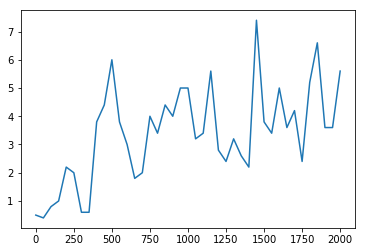

In [22]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [24]:
import os
tmp = GAME_NAME.split('/')[1]
#os.mkdir(tmp)
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [24]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

[2017-06-27 00:53:48,300] Making new env: ppaquette/DoomBasic-v0
[2017-06-27 00:53:48,307] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-27 00:53:48,551] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.17632.video000000.mp4
[2017-06-27 00:53:48,870] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.17632.video000001.mp4


Episode finished after 7 timesteps with reward=66.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 9 timesteps with reward=56.0


[2017-06-27 00:53:49,595] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.17632.video000008.mp4


Episode finished after 6 timesteps with reward=71.0
Episode finished after 9 timesteps with reward=56.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 18 timesteps with reward=7.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 5 timesteps with reward=76.0


[2017-06-27 00:53:52,517] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.17632.video000027.mp4


Episode finished after 3 timesteps with reward=86.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 9 timesteps with reward=56.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 8 timesteps with reward=61.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 7 timesteps with reward=66.0
Episode fini

[2017-06-27 00:53:55,977] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.17632.video000064.mp4


Episode finished after 7 timesteps with reward=66.0
Episode finished after 14 timesteps with reward=31.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 9 timesteps with reward=56.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 9 timesteps with reward=56.0
Episode finished after 20 timesteps with reward=1.0
Episode 

[2017-06-27 00:54:00,080] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 7 timesteps with reward=66.0
Episode finished after 8 timesteps with reward=61.0
Episode finished after 6 timesteps with reward=71.0
mean session score=63.200000


In [25]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets